Epoch 1/25
33/33 [==============================] - 22s 223ms/step - loss: 0.0454
Epoch 2/25
33/33 [==============================] - 6s 181ms/step - loss: 0.0149
Epoch 3/25
33/33 [==============================] - 4s 119ms/step - loss: 0.0124
Epoch 4/25
33/33 [==============================] - 4s 125ms/step - loss: 0.0120
Epoch 5/25
33/33 [==============================] - 6s 187ms/step - loss: 0.0112
Epoch 6/25
33/33 [==============================] - 5s 142ms/step - loss: 0.0108
Epoch 7/25
33/33 [==============================] - 5s 157ms/step - loss: 0.0093
Epoch 8/25
33/33 [==============================] - 5s 136ms/step - loss: 0.0085
Epoch 9/25
33/33 [==============================] - 4s 133ms/step - loss: 0.0088
Epoch 10/25
33/33 [==============================] - 5s 151ms/step - loss: 0.0076
Epoch 11/25
33/33 [==============================] - 5s 146ms/step - loss: 0.0072
Epoch 12/25
33/33 [==============================] - 5s 140ms/step - loss: 0.0068
Epoch 13/25
33/33 [=====

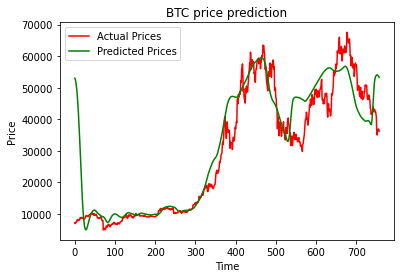

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

crypto_currency = 'BTC'
against_cryptocurrency = 'USD'

start = dt.datetime(2019,1,1)
end = dt.datetime.now()

data =  web.DataReader(f'{crypto_currency}-{against_cryptocurrency}', 'yahoo', start, end)

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

prediction_days = 60
future_day = 30

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


# Create Neutral Network

model = Sequential()

model.add(LSTM(units = 50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

#Testing the model

test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data =  web.DataReader(f'{crypto_currency}-{against_cryptocurrency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.plot(actual_prices, color='red', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()


## Predict the next day
### real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs) + 1, 0]]
### real_data = np.array(real_data)
### real_data = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
### prediction = model.predict(real_data)
### prediction = scaler.inverse_transform(prediction)
### print()